In [69]:
import pandas as pd
import info_theory
import plotting
import preprocess
import network
import networkx as nx
from scipy.linalg import eigh
import os
import backboning

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
np.math = math
from idtxl.data import Data
from idtxl.multivariate_te import MultivariateTE
from idtxl.visualise_graph import plot_network
import pickle

In [7]:
# Define assets and file paths
assets = ["commodity", "credit", "currency", "energy", "equity", "interest", "metals", "real_estate", "volatility"]
file_paths = {asset: f"../data/{asset}_data.xlsx" for asset in assets}

# Load data
aligned_data, tickers = preprocess.load_and_align_data(file_paths)

# Drop tickers with many missing points
aligned_data, tickers = preprocess.drop_short_tickers(aligned_data, tickers, max_nan=50)
aligned_data['GB03'] + 0.1

# Compute log returns
log_returns = preprocess.compute_log_returns(aligned_data)

# Interest data has negative and zero values
# interest_data = aligned_data[tickers['interest']]
# log_returns[tickers["interest"]] = interest_data

# Drop NA
log_returns = log_returns.dropna()

Tickers to drop/replace due to insufficient data:
['FXJPEMCS', 'QCLN']


c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [11]:
def idtxl_te_values(results):
    n_nodes = len(results.targets_analysed)
    te_matrix = np.zeros((n_nodes, n_nodes))

    for target in results.targets_analysed:
        res = results.get_single_target(target, fdr=False)

        te_vals = res["selected_sources_te"]
        if te_vals is None:
            continue
        
        sources = [src for src, _ in res["selected_vars_sources"]]

        for src, te in zip(sources, te_vals):
            te_matrix[src, target] = te
    
    return te_matrix

In [12]:
def adj_matrix_to_graph(data, adj_matrix):
    node_labels = data.columns
    G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
    mapping = {i: name for i, name in enumerate(node_labels)}
    G = nx.relabel_nodes(G, mapping)
    return G

In [51]:
def network_properties(G):

    analysis = {}

    in_degrees = dict(G.in_degree(weight="weight"))
    out_degrees = dict(G.out_degree(weight="weight"))
    analysis['in_degree'] = pd.Series(in_degrees)
    analysis['out_degree'] = pd.Series(out_degrees)
    analysis['betweenness_centr'] = nx.betweenness_centrality(G, weight="weight")
    analysis['e_vector_centr'] = nx.eigenvector_centrality(G, weight="weight")
    analysis['clustering'] = nx.clustering(G, weight="weight")
    return pd.DataFrame(analysis)

In [117]:
tickers

{'commodity': ['BCOM', 'CRB CMDT', 'CRB METL', 'CRB RIND', 'SPGSAGP'],
 'credit': ['MOODCAAA', 'LF98TRUU', 'DJCBP', 'LMBITR', 'LC07TRUU'],
 'currency': ['DXY', 'BBDXY'],
 'energy': ['MXWO0EN', 'SPGSEN'],
 'equity': ['SPX', 'NDX', 'RTY', 'CCMP', 'SML', 'SGX'],
 'interest': ['GB03', 'GT02', 'GT10'],
 'metals': ['BCOMPR', 'DJGSP'],
 'real_estate': ['REIT', 'DJUSRE', 'EPRA'],
 'volatility': ['VIX', 'VXN']}

Your graph is directed!
100%|██████████| 30/30 [00:00<00:00, 531.40it/s]


,in_degree,out_degree,betweenness_centr,e_vector_centr,clustering
BCOM,0.001919,0.495847,0.005291,1.294965e-07,0.035862
CRB CMDT,1.436054,0.128487,0.018519,4.661815e-01,0.147360
CRB METL,0.764984,0.652877,0.025132,1.294518e-01,0.115945
CRB RIND,1.078465,0.158963,0.030423,2.302609e-01,0.060072
SPGSAGP,0.000000,0.828036,0.000000,1.206972e-07,0.153171
MOODCAAA,0.005862,0.240320,0.017196,1.482469e-07,0.062608
LF98TRUU,0.596756,0.855820,0.063492,7.062693e-02,0.097977
DJCBP,0.672395,0.260795,0.041005,1.161427e-01,0.070957
LMBITR,0.840121,0.314127,0.014550,2.207438e-01,0.131167
LC07TRUU,1.528061,0.497655,0.013228,4.017017e-01,0.152476


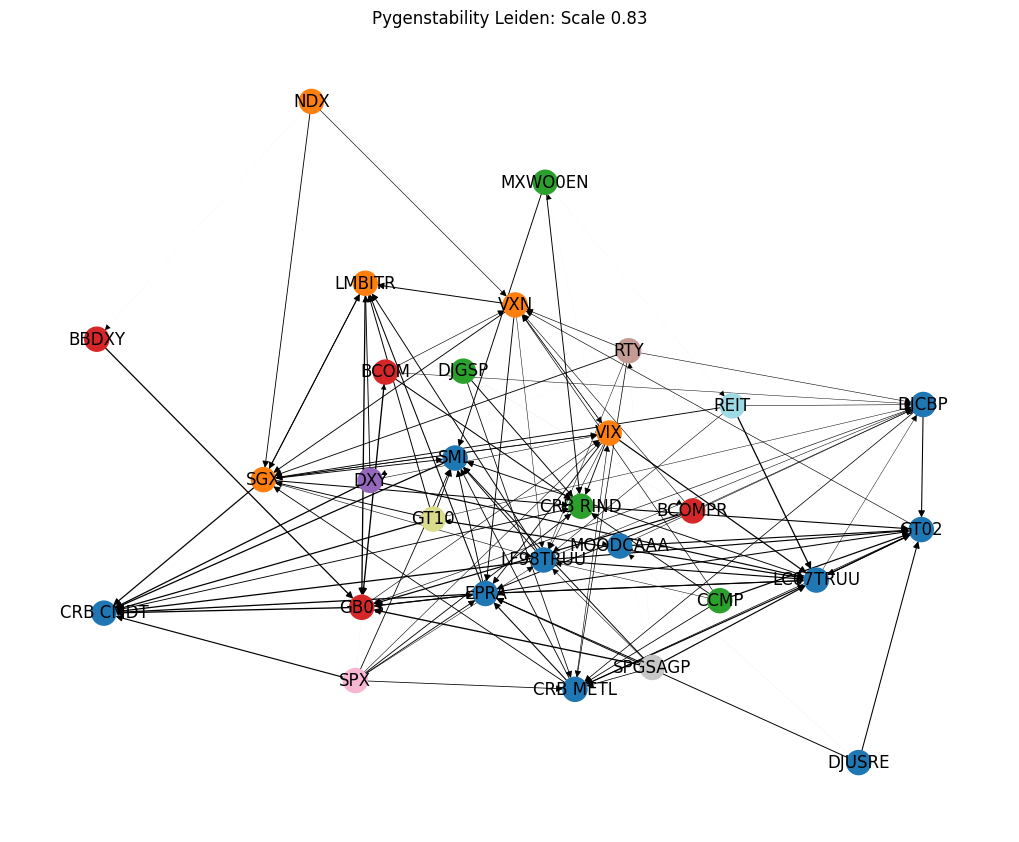

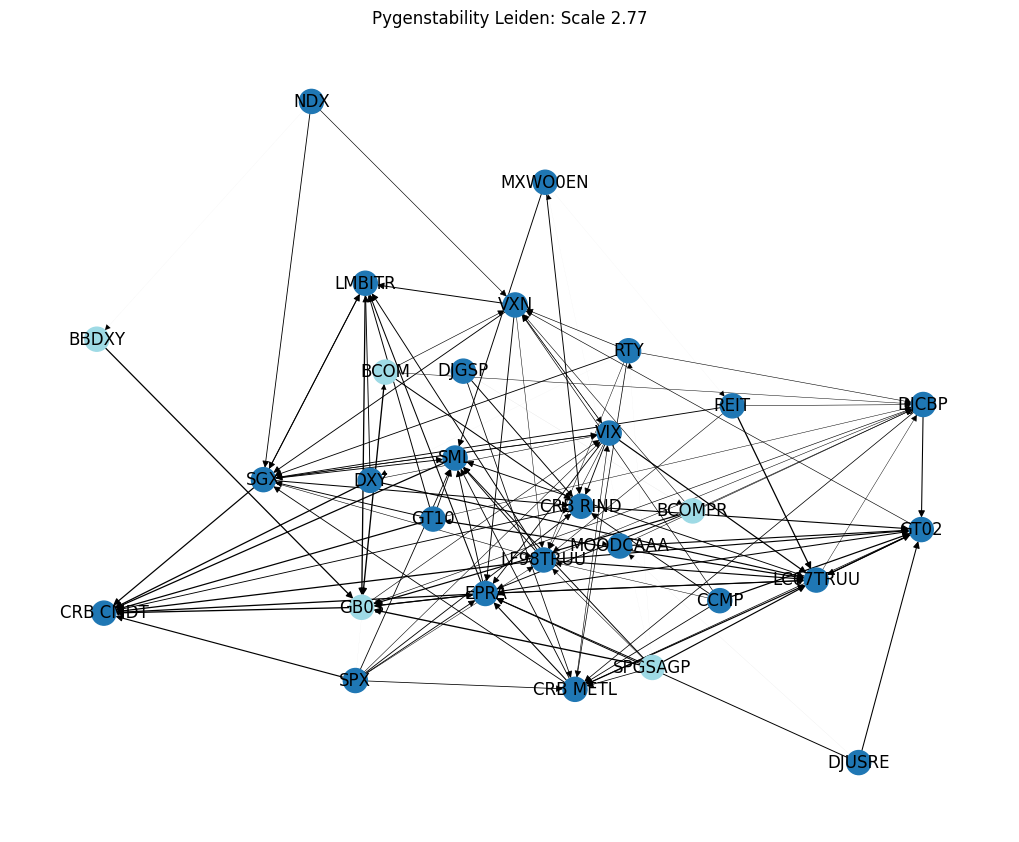

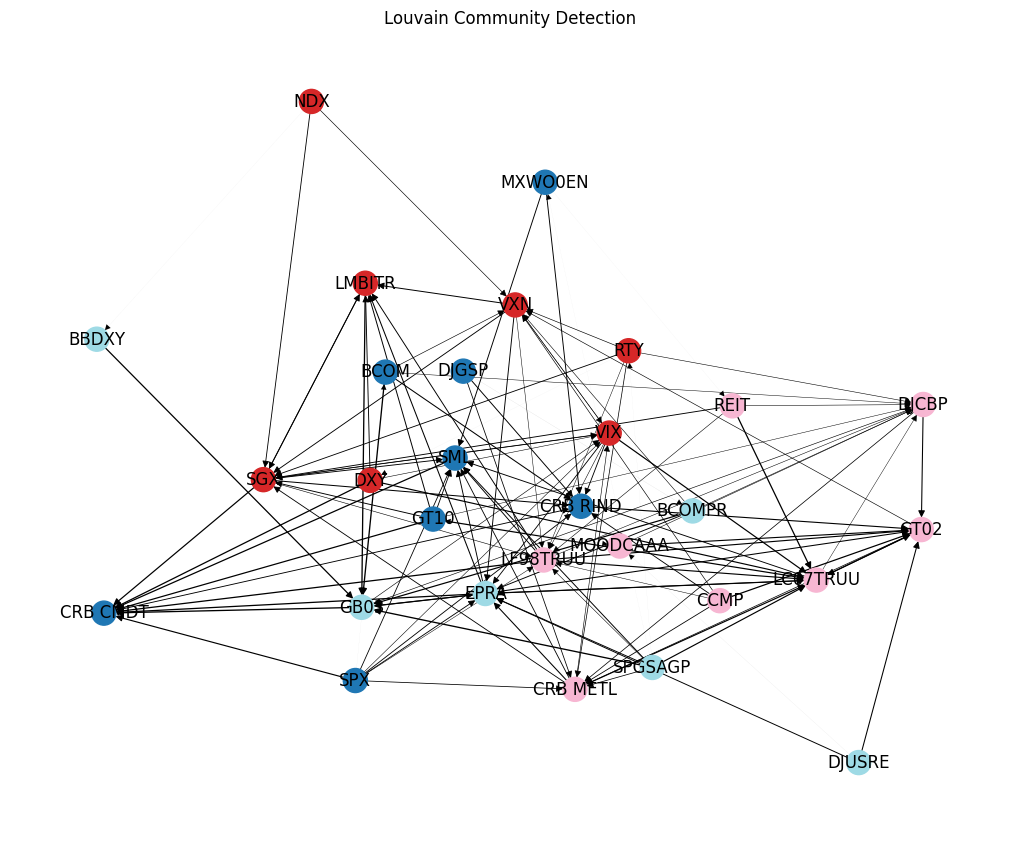

In [120]:
with open("idtxl_log_returns_tickers_discrete_equal_freq_2_bins", "rb") as f:
    results = pickle.load(f)

te_matrix = idtxl_te_values(results)
G = adj_matrix_to_graph(log_returns, te_matrix)
largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
G_largest_cc = G.subgraph(largest_cc).copy()
network.custom_plot_communities(G_largest_cc)
network_properties(G_largest_cc)

In [118]:
ticker_to_class = {ticker: cls 
                   for cls, assets in tickers.items()
                   for ticker in assets}

In [123]:
def class_average_properties(G):
    df = network_properties(G)
    df['asset_class'] = df.index.map(ticker_to_class)
    class_averages = df.groupby('asset_class').mean()
    return class_averages

class_average_properties(G_largest_cc)

,in_degree,out_degree,betweenness_centr,e_vector_centr,clustering
asset_class,,,,,
commodity,0.656284,0.452842,0.015873,1.651789e-01,0.102482
credit,0.728639,0.433743,0.029894,1.618431e-01,0.103037
currency,0.001963,0.369236,0.007275,1.298888e-07,0.017165
energy,0.001843,0.274199,0.006614,1.291485e-07,0.014318
equity,0.366470,0.499411,0.008598,8.352401e-02,0.123186
interest,0.796171,0.556894,0.035714,2.136080e-01,0.114181
metals,0.002483,0.364989,0.006614,1.320839e-07,0.069551
real_estate,0.409256,0.576628,0.014991,1.028466e-01,0.136868
volatility,0.538571,0.627497,0.062831,1.113990e-01,0.101611


Your graph is directed!
100%|██████████| 30/30 [00:00<00:00, 516.98it/s]


,in_degree,out_degree,betweenness_centr,e_vector_centr,clustering
BCOM,0.896465,2.154819,0.168719,0.169932,0.064550
CRB CMDT,0.902770,0.865585,0.011084,0.174012,0.077902
CRB METL,0.884796,1.351257,0.064039,0.256239,0.000000
CRB RIND,0.891540,0.835587,0.108374,0.133897,0.000000
SPGSAGP,0.453789,2.988425,0.070197,0.066786,0.049209
MOODCAAA,0.926004,0.432048,0.030788,0.169209,0.153623
LF98TRUU,0.184843,0.379310,0.075123,0.027204,0.000000
DJCBP,0.911368,1.689492,0.094828,0.135391,0.000000
LMBITR,0.177918,0.464397,0.045567,0.035617,0.000000
LC07TRUU,0.909823,2.200493,0.045567,0.165245,0.046945


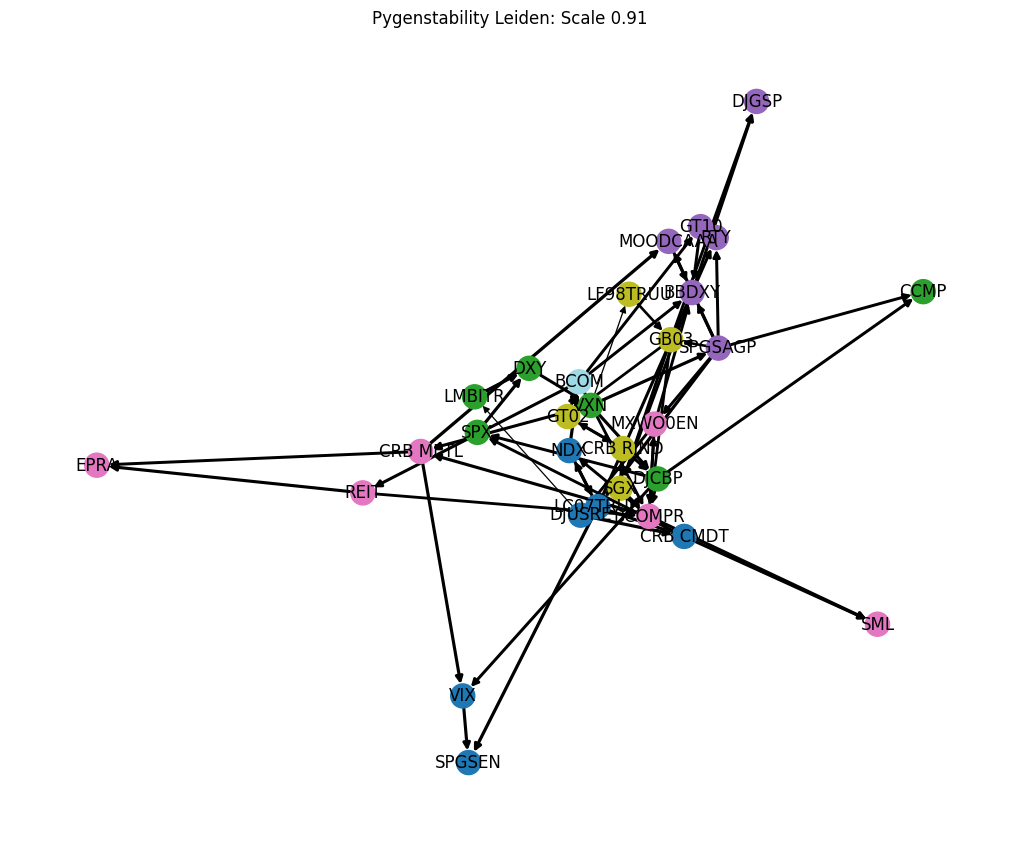

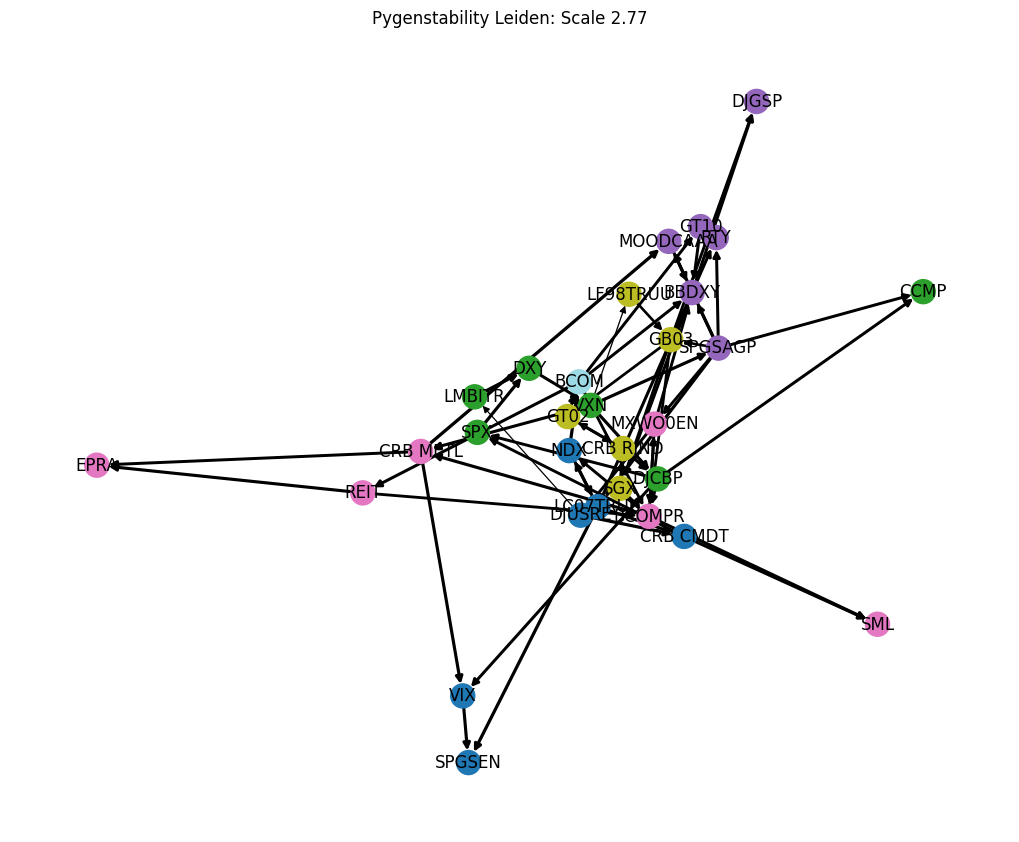

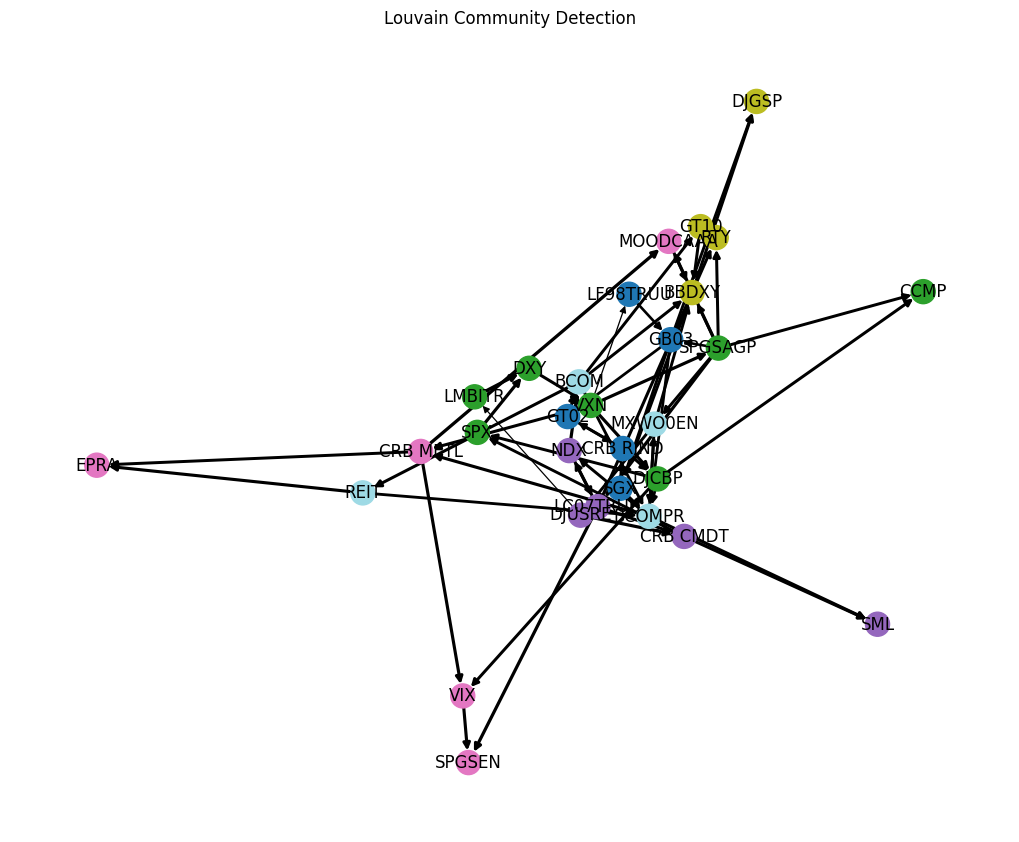

In [124]:
with open("idtxl_log_returns_tickers_discrete_equal_freq_3_bins", "rb") as f:
    results = pickle.load(f)

te_matrix = idtxl_te_values(results)
G = adj_matrix_to_graph(log_returns, te_matrix)
largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
G_largest_cc = G.subgraph(largest_cc).copy()
network.custom_plot_communities(G_largest_cc)
network_properties(G_largest_cc)

In [125]:
class_average_properties(G_largest_cc)

,in_degree,out_degree,betweenness_centr,e_vector_centr,clustering
asset_class,,,,,
commodity,0.805872,1.639135,0.084483,0.160173,0.038332
credit,0.621991,1.033148,0.058374,0.106533,0.040114
currency,1.522106,0.649831,0.155788,0.226732,0.032387
energy,0.883236,0.628133,0.048030,0.199085,0.024750
equity,0.863093,0.444604,0.055008,0.181779,0.053434
interest,0.795037,0.978098,0.085796,0.083298,0.060042
metals,1.651157,0.874335,0.130542,0.288094,0.015161
real_estate,0.717626,0.497826,0.023399,0.142057,0.075394
volatility,0.885025,0.988752,0.128079,0.163149,0.000000


Your graph is directed!


100%|██████████| 30/30 [00:00<00:00, 439.65it/s]


,in_degree,out_degree,betweenness_centr,e_vector_centr,clustering
BCOM,1.078692,0.340589,0.004926,0.244137,0.285727
CRB CMDT,0.475186,0.344644,0.036946,0.097506,0.051911
CRB METL,0.809565,0.346437,0.008621,0.175079,0.117562
CRB RIND,1.305715,0.672998,0.019704,0.319932,0.204649
SPGSAGP,0.892789,1.949915,0.033251,0.141749,0.148875
MOODCAAA,0.808434,0.503264,0.029557,0.158684,0.144255
LF98TRUU,0.770368,1.568043,0.068966,0.102919,0.166618
DJCBP,1.246894,0.910127,0.024631,0.234366,0.168809
LMBITR,0.927385,0.503334,0.028325,0.205884,0.176551
LC07TRUU,0.760085,1.148665,0.036946,0.144908,0.152073


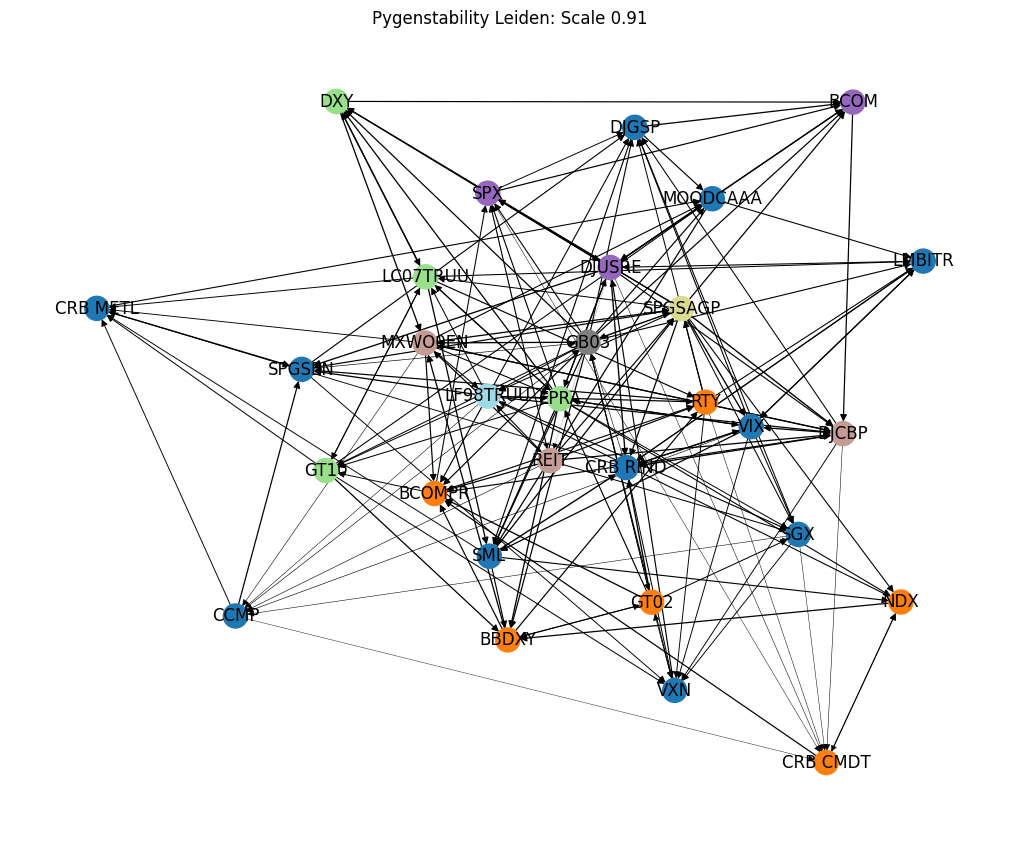

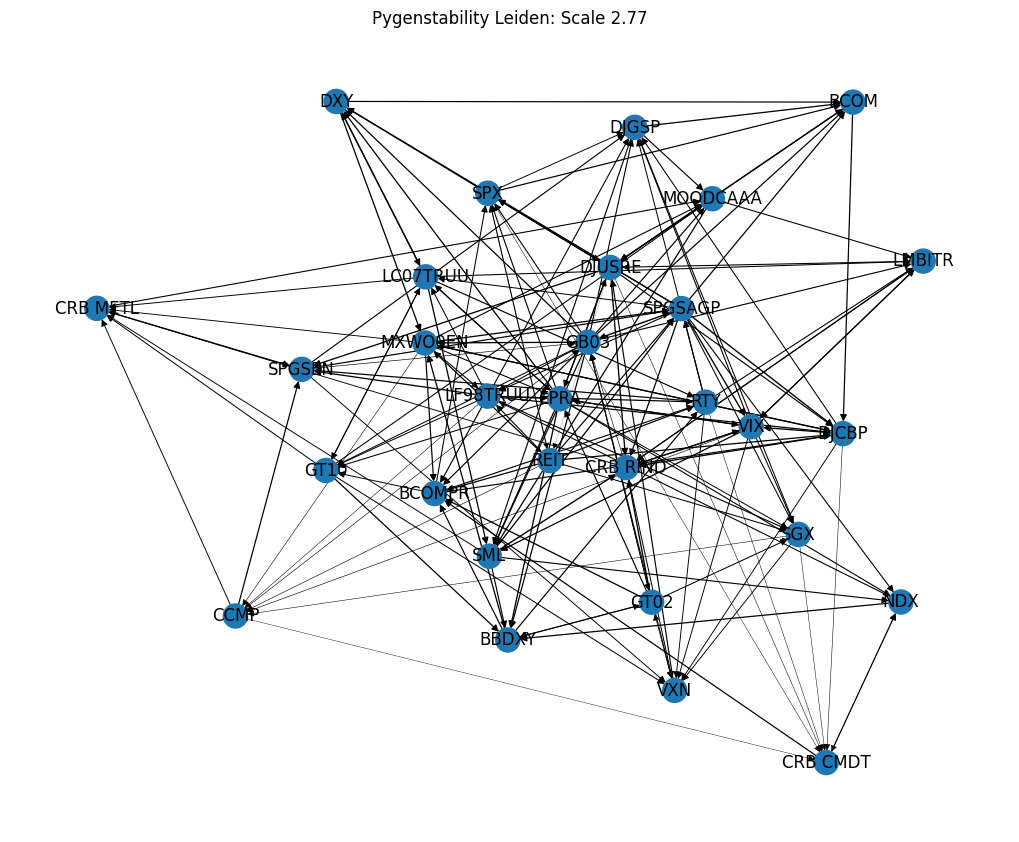

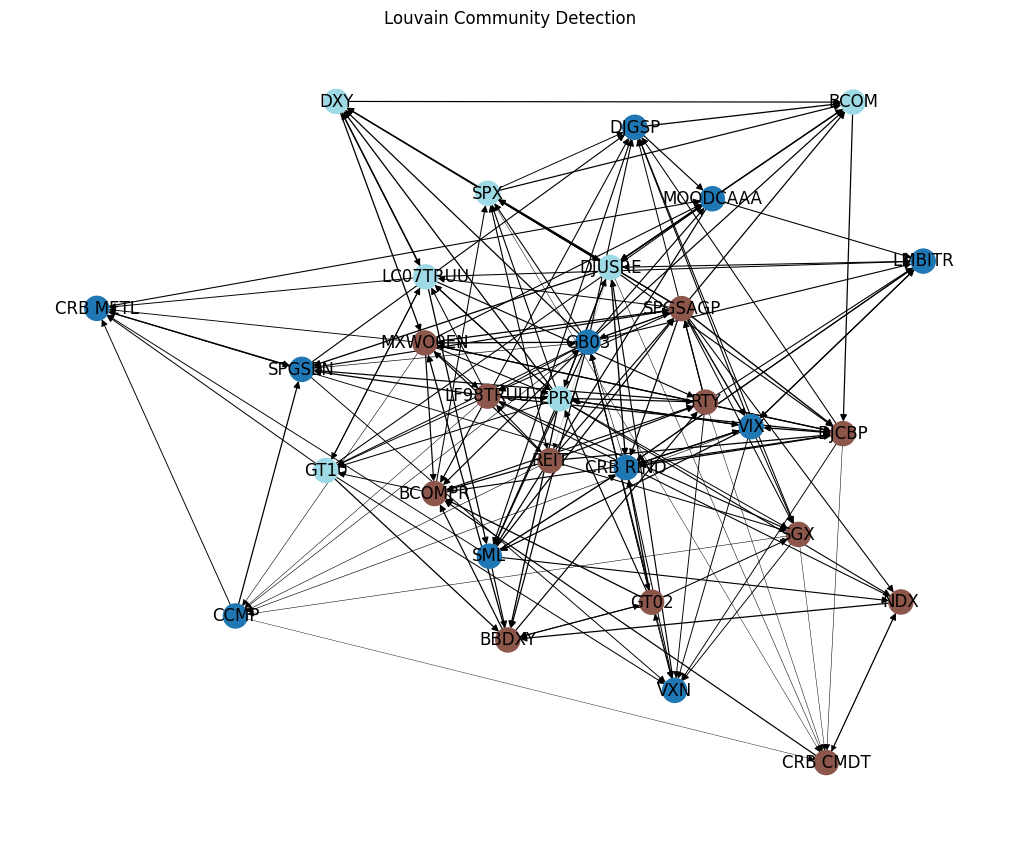

In [66]:
with open("idtxl_abs_log_returns_tickers_discrete_equal_freq_2_bins", "rb") as f:
    results = pickle.load(f)

te_matrix = idtxl_te_values(results)
G = adj_matrix_to_graph(log_returns, te_matrix)
largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
G_largest_cc = G.subgraph(largest_cc).copy()
network.custom_plot_communities(G_largest_cc)
network_properties(G_largest_cc)

Your graph is directed!


100%|██████████| 30/30 [00:00<00:00, 590.04it/s]


,in_degree,out_degree,betweenness_centr,e_vector_centr,clustering
BCOM,0.879811,0.823802,0.075123,9.549878e-02,0.000000
CRB CMDT,0.915363,0.446466,0.046798,2.226834e-01,0.000000
CRB METL,0.899344,2.099369,0.174877,2.349327e-01,0.106431
CRB RIND,0.893263,0.880023,0.134236,2.411545e-01,0.000000
SPGSAGP,0.886479,1.693825,0.350985,2.610263e-01,0.030114
MOODCAAA,0.907221,1.269505,0.052956,2.349247e-01,0.088847
LF98TRUU,0.708744,0.000000,0.000000,1.042409e-01,0.000000
DJCBP,0.897427,0.850899,0.054187,2.069752e-01,0.000000
LMBITR,0.821486,0.000000,0.000000,1.771867e-01,0.000000
LC07TRUU,0.869138,0.440154,0.128079,1.990506e-01,0.000000


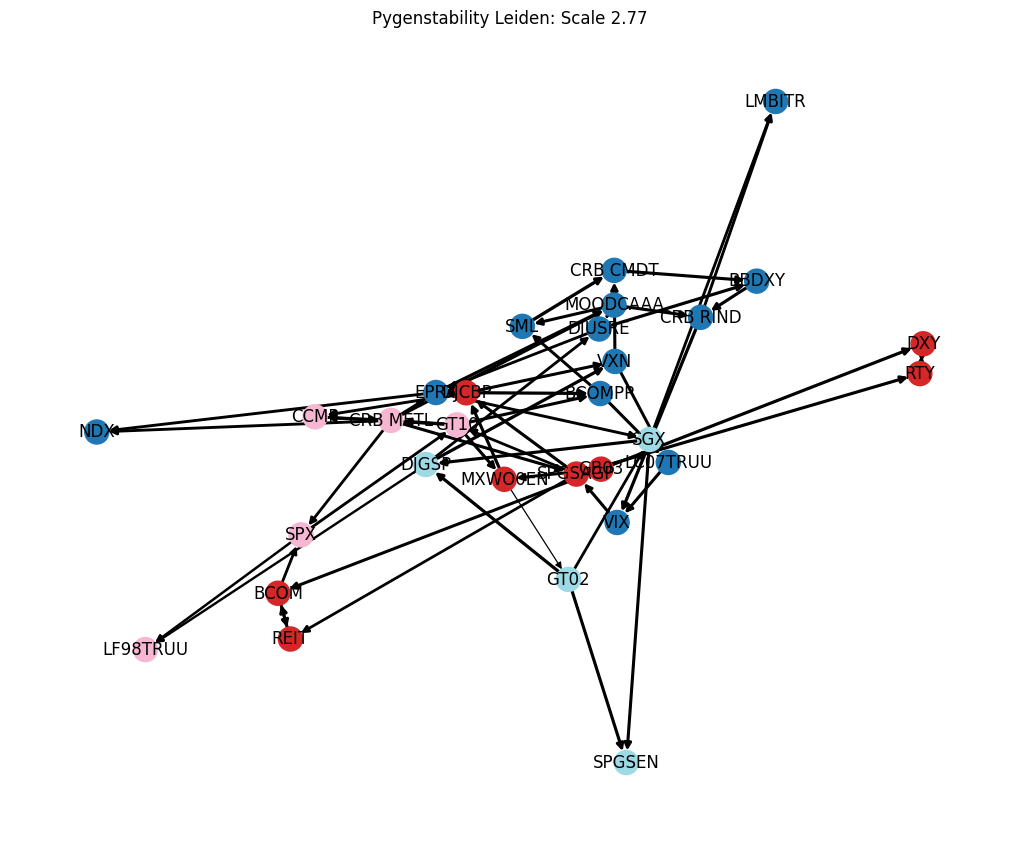

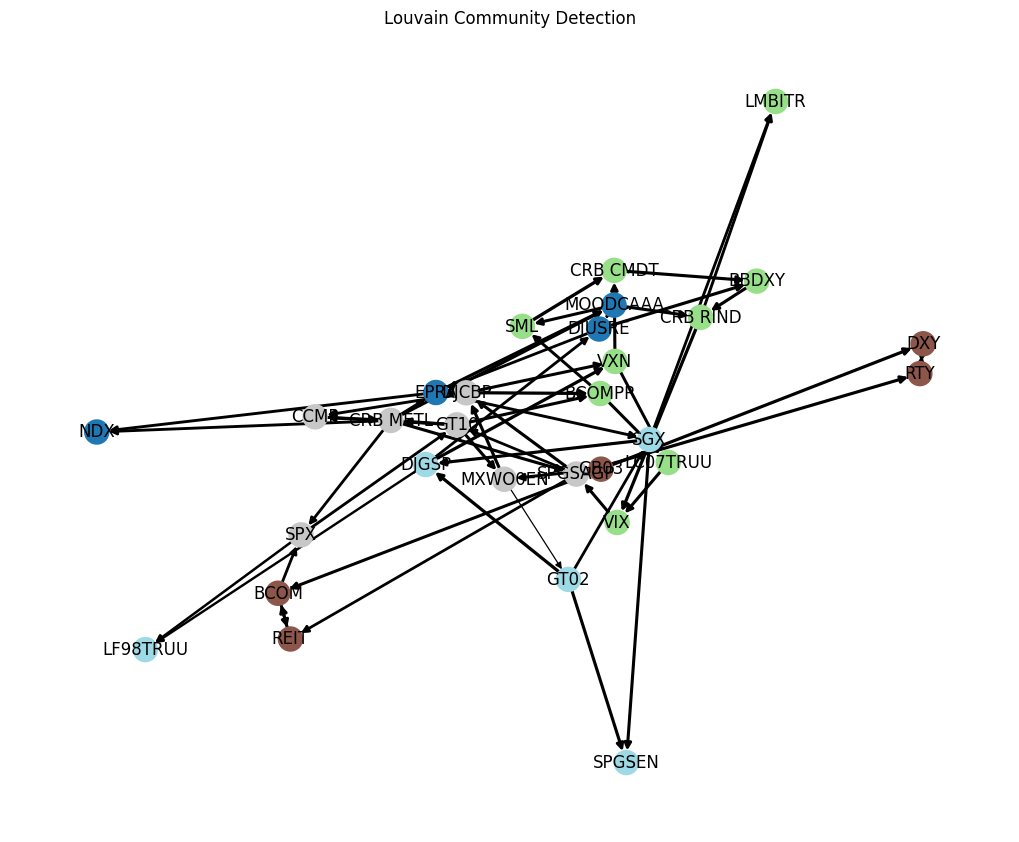

In [67]:
with open("idtxl_abs_log_returns_tickers_discrete_equal_freq_3_bins", "rb") as f:
    results = pickle.load(f)

te_matrix = idtxl_te_values(results)
G = adj_matrix_to_graph(log_returns, te_matrix)
largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
G_largest_cc = G.subgraph(largest_cc).copy()
network.custom_plot_communities(G_largest_cc)
network_properties(G_largest_cc)

In [75]:
def max_spanning_tree(graph):
    # Prepare graph for backboning package
    edges = [(u, v , d["weight"]) for u, v, d in graph.edges(data=True)]
    df_edges = pd.DataFrame(edges, columns=["src", "trg", "weight"])
    df_edges.to_csv(f"edges.csv", index=False)
    table, _, _ = backboning.read(f".\edges.csv", 
                                             column_of_interest="weight", 
                                             sep=",", 
                                             undirected=True)
    os.remove(f"edges.csv")
        
    backbone_table = backboning.maximum_spanning_tree(table)

    # Turn table back into graph
    G_backbone = nx.Graph()
    for _, row in backbone_table.iterrows():
        G_backbone.add_edge(row["src"], row["trg"], weight=row["nij"])

    return G_backbone

In [76]:
g = max_spanning_tree(G)

Calculating MST score...


In [89]:
fixed_pos = nx.spring_layout(g, seed=21)

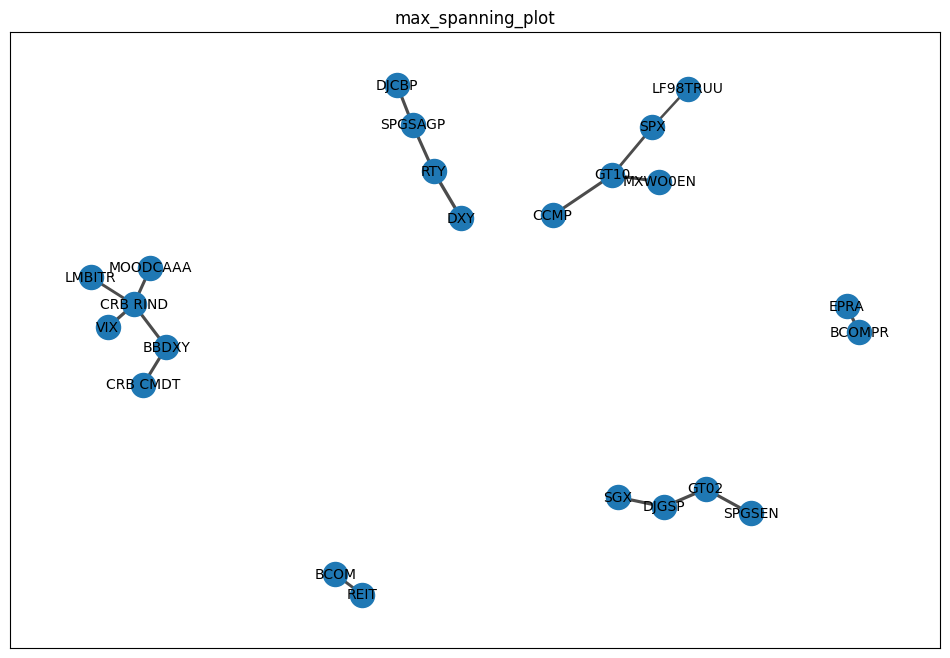

In [91]:
network.plot_graph(g, fixed_pos, "max_spanning_plot")

# Sliding windows

In [86]:
import plotly.graph_objects as go
def create_measure_heatmap(measure_matrix, assets, endpoints, 
                         measure_name="measure", window_len="2", colorscale="Viridis"):
    num_windows = measure_matrix.shape[2]
    
    frames = [
        go.Frame(
            name=f"Window {t}",
            data=go.Heatmap(
                z=measure_matrix[:, :, t],
                x=assets,
                y=assets,
                colorscale=colorscale,
                # Ensure square aspect ratio
                hoverongaps=False,
                showscale=True
            )
        )
        for t in range(num_windows)
    ]
    
    slider_steps = [{
        "args": [[f"Window {t}"], {"frame": {"duration": 0}, "mode": "immediate"}],
        "label": str(endpoints[t].year),
        "method": "animate"
    } for t in range(num_windows)]
    
    fig = go.Figure(
        data=frames[0].data,
        frames=frames,
        layout=go.Layout(
            title=f"{measure_name} Heatmap Over Time",
            sliders=[{
                "active": 0,
                "steps": slider_steps,
                "currentvalue": {
                    "font": {"size": 20},
                    "prefix": f"{window_len} Year(s) up to: ", 
                    "xanchor": "right"},
                "pad": {"b": 10, "t": 50}
            }],
            # Add these layout adjustments
            height=800,  # Increase height
            margin=dict(l=120),  # Add left margin for labels
            yaxis=dict(
                tickangle=-45,  # Rotate labels
                tickfont=dict(size=10)  # Smaller font
            ),
            xaxis=dict(
                tickangle=45,
                tickfont=dict(size=10)
            )
        )
    )
    return fig

In [107]:
with open("idtxl_windows_6_3_log_returns_tickers_discrete_equal_freq_2_bins", "rb") as f:
    windows_results = pickle.load(f)

In [93]:
def idtxl_3d_te_matrix(windows_results):
    n_nodes = len(windows_results[0].targets_analysed)
    n_windows = len(windows_results)

    te_matrix_3d = np.zeros((n_nodes, n_nodes, n_windows))

    for t, results in enumerate(windows_results):
        te_matrix_3d[:, :, t] = idtxl_te_values(results)

    return te_matrix_3d

In [108]:
te_matrix_3d = idtxl_3d_te_matrix(windows_results)

In [109]:
tickers

{'commodity': ['BCOM', 'CRB CMDT', 'CRB METL', 'CRB RIND', 'SPGSAGP'],
 'credit': ['MOODCAAA', 'LF98TRUU', 'DJCBP', 'LMBITR', 'LC07TRUU'],
 'currency': ['DXY', 'BBDXY'],
 'energy': ['MXWO0EN', 'SPGSEN'],
 'equity': ['SPX', 'NDX', 'RTY', 'CCMP', 'SML', 'SGX'],
 'interest': ['GB03', 'GT02', 'GT10'],
 'metals': ['BCOMPR', 'DJGSP'],
 'real_estate': ['REIT', 'DJUSRE', 'EPRA'],
 'volatility': ['VIX', 'VXN']}

In [110]:
window_len = 6
window_step = 3
windows = preprocess.sliding_window(log_returns, 
                                    window_len, 
                                    window_step, 
                                    window_unit="years", 
                                    step_unit="years")
endpoints = [end_date for _, end_date, _ in windows]
create_measure_heatmap(te_matrix_3d, 
                                log_returns.columns, 
                                endpoints,
                                window_len=6,
                                measure_name="Multivariate Transfer Entropy")

In [111]:
with open("idtxl_windows_2_1_log_returns_tickers_discrete_equal_freq_3_bins", "rb") as f:
    windows_results = pickle.load(f)

In [112]:
te_matrix_3d = idtxl_3d_te_matrix(windows_results)

In [116]:
window_len = 2
window_step = 1
windows = preprocess.sliding_window(log_returns, 
                                    window_len, 
                                    window_step, 
                                    window_unit="years", 
                                    step_unit="years")
endpoints = [end_date for _, end_date, _ in windows]
create_measure_heatmap(te_matrix_3d, 
                                log_returns.columns, 
                                endpoints,
                                window_len=2,
                                measure_name="Multivariate Transfer Entropy")
